2025-08-24 19:36:02,837 - INFO - Loading data from C:\Users\DAIICT I\Desktop\Msc DS Sujal 202418017\Interval_Forecast_Normal\df_without_exo.xlsx...
2025-08-24 19:36:02,951 - INFO - Engineering lagged features...
2025-08-24 19:36:02,953 - INFO - Splitting test data at date: 2024-04-01
2025-08-24 19:36:02,955 - INFO - Train size: 750, Validation size: 84, Test size: 89
2025-08-24 19:36:02,958 - INFO - Starting hyperparameter search over 2268 combinations...
2025-08-24 19:36:04,015 - INFO - ✓ Valid model found: PICP=100.00%, MPIW=33.7308, CRPS=16.6863 with params {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.005, 'epochs': 100, 'q': 0.95, 'r': 0.4, 'delta': 0.0}
2025-08-24 19:36:04,153 - INFO - ✓ Valid model found: PICP=100.00%, MPIW=23.7592, CRPS=17.0275 with params {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.005, 'epochs': 100, 'q': 0.95, 'r': 0.4, 'delta': 0.01}
2025-08-24 19:36:04,277 - INFO - ✗ Model rejected: PICP=86.75% with params {'


Best Hyperparameters: {'seq_len': 30, 'hidden_dim': 64, 'num_layers': 2, 'learning_rate': 0.01, 'epochs': 100, 'q': 0.95, 'r': 0.4, 'delta': 0.1}
Prediction Interval Coverage (PICP): 96.61%
Mean Prediction Interval Width (MPIW): 19.8995
Continuous Ranked Probability Score (CRPS): 16.4689



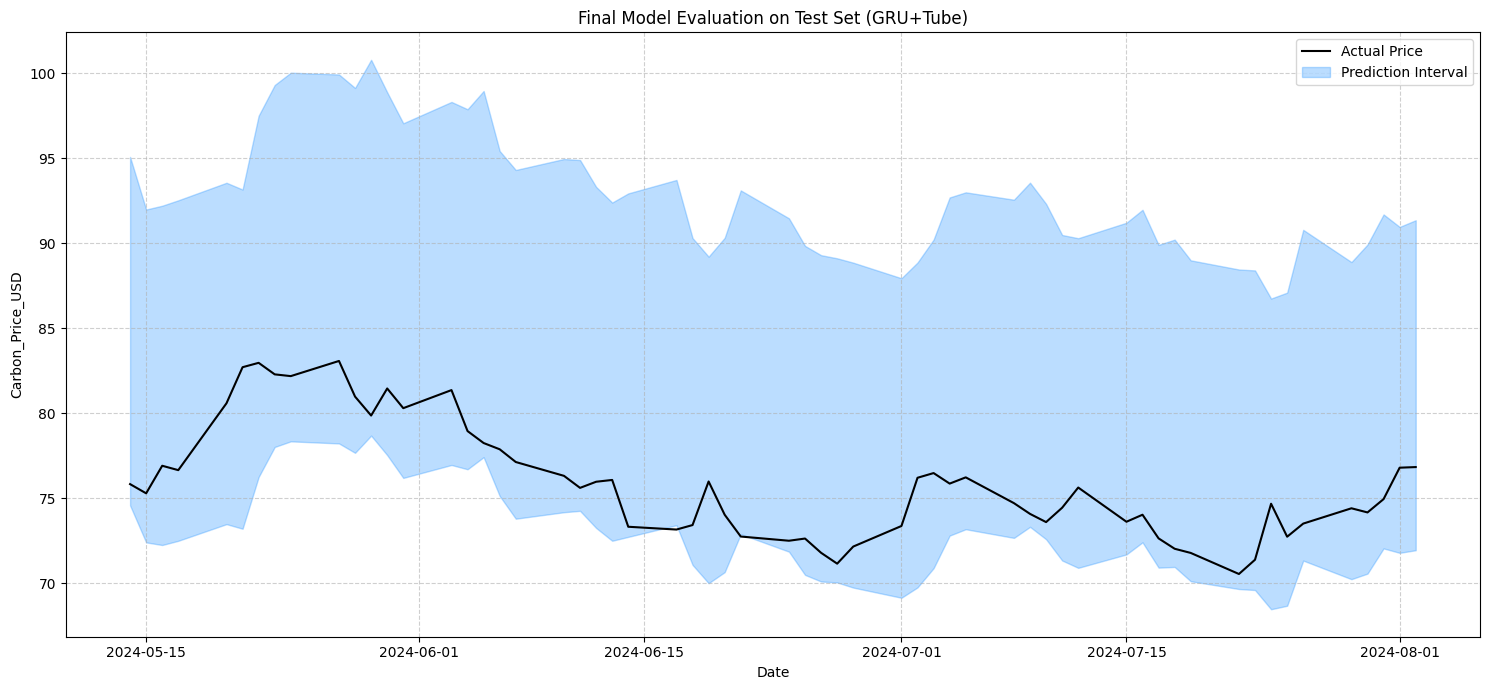

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import itertools
import logging

# torch.manual_seed(42)
# np.random.seed(42)

# --- 1. Configuration ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

CONFIG = {
    "file_path": r"C:\Users\DAIICT I\Desktop\Msc DS Sujal 202418017\Interval_Forecast_Normal\df_without_exo.xlsx",
    "target_col": "Carbon_Price_USD",
    "original_features": ['Open', 'High', 'Low', 'Carbon_Price_USD', 'Vol.', 'Change %'],
    
    # --- Splitting Logic ---
    "test_split_date": '2024-04-01',
    "val_ratio_of_train_data": 0.1,
    
    "target_coverage": 95.0,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    
    "param_grid": {
        'seq_len': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30],
        'hidden_dim': [32, 64, 128],
        'num_layers': [1, 2, 3],
        'learning_rate': [0.005, 0.01],
        'epochs': [100],
        # --- Tube Loss Hyperparameters to be Tuned ---
        'q': [0.95],
        'r': [0.4, 0.5, 0.6],
        'delta': [0.0, 0.01, 0.1]
    }
}

# --- 2. Model Definition & Loss Function ---

class GRUTube(nn.Module):
    """GRU model designed to output two values for the prediction interval."""
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        # CHANGED: Use nn.GRU instead of nn.LSTM
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        # The final layer still outputs 2 values
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

def confidence_loss(y_pred, y_true, q, r, delta):
    # This loss function remains the same
    y_true = y_true.squeeze(-1)
    f2 = y_pred[:, 0]
    f1 = y_pred[:, 1]
    crossover_penalty = torch.mean(torch.relu(f1 - f2))
    c1 = (1 - q) * (f2 - y_true)
    c2 = (1 - q) * (y_true - f1)
    c3 = q * (f1 - y_true)
    c4 = q * (y_true - f2)
    loss_part1 = torch.where(y_true > r * (f1 + f2), c1, c2)
    loss_part2 = torch.where(f1 > y_true, c3, c4)
    is_inside = torch.logical_and(y_true <= f2, y_true >= f1)
    width_penalty = delta * torch.abs(f1 - f2)
    final_loss = torch.where(is_inside, loss_part1, loss_part2) + width_penalty
    return torch.mean(final_loss) + crossover_penalty

# --- CRPS Score Function ---
def crps_score(y_true, pred_lower, pred_upper):
    """
    Calculates the CRPS for a quantile-based forecast.
    This is an approximation based on the two quantiles.
    
    Args:
        y_true (np.array): The true values.
        pred_lower (np.array): The lower quantile predictions (e.g., 2.5th).
        pred_upper (np.array): The upper quantile predictions (e.g., 97.5th).

    Returns:
        float: The average CRPS score.
    """
    alpha = 0.05  # For a 95% interval (1 - alpha)
    
    crps = np.mean(
        (y_true - pred_lower) * ((y_true > pred_lower) - (1 - alpha / 2)) +
        (pred_upper - y_true) * ((y_true < pred_upper) - (alpha / 2))
    )
    return crps

# --- 3. Pipeline Functions ---

def load_and_clean_data(file_path):
    # This function remains the same
    logging.info(f"Loading data from {file_path}...")
    df = pd.read_excel(file_path) 
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.sort_values('Date', inplace=True)
    if pd.api.types.is_object_dtype(df['Vol.']):
        def convert_volume(vol):
            try:
                if isinstance(vol, str):
                    vol = vol.replace('K', '*1e3').replace('M', '*1e6')
                    return eval(vol)
                return np.nan
            except: return np.nan
        df['Vol.'] = df['Vol.'].apply(convert_volume)
    df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')
    df['Change %'] = pd.to_numeric(df['Change %'], errors='coerce')
    df.set_index('Date', inplace=True)
    return df

def engineer_features(df, original_features, target_col):
    # This function remains the same
    logging.info("Engineering lagged features...")
    for feature in original_features:
        df[f'{feature}_lag1'] = df[feature].shift(1)
    feature_cols = [f'{col}_lag1' for col in original_features]
    df.dropna(inplace=True)
    if df.empty:
        raise ValueError("DataFrame is empty after feature engineering.")
    X = df[feature_cols]
    y = df[[target_col]]
    return X, y

def split_and_scale_data(X, y, test_split_date, val_ratio):
    # This function remains the same
    logging.info(f"Splitting test data at date: {test_split_date}")
    test_split_date = pd.to_datetime(test_split_date)
    train_val_mask = X.index < test_split_date
    X_train_val, X_test = X[train_val_mask], X[~train_val_mask]
    y_train_val, y_test = y[train_val_mask], y[~train_val_mask]
    val_split_index = int(len(X_train_val) * (1 - val_ratio))
    X_train, X_val = X_train_val[:val_split_index], X_train_val[val_split_index:]
    y_train, y_val = y_train_val[:val_split_index], y_train_val[val_split_index:]
    logging.info(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")
    if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
         raise ValueError("One of the data splits is empty.")
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train)
    X_val_scaled = scaler_X.transform(X_val)
    y_val_scaled = scaler_y.transform(y_val)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)
    return (X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, 
            X_test_scaled, y_test_scaled, scaler_y)

def create_sequences(X, y, seq_len):
    # This function remains the same
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i - seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

def train_tube_model(X_train, y_train, params):
    """Trains a single GRU Tube model."""
    # CHANGED: Instantiate GRUTube instead of LSTMTube
    model = GRUTube(
        X_train.shape[2], 
        params['hidden_dim'], 
        params['num_layers']
    ).to(CONFIG['device'])
    
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(CONFIG['device'])
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(CONFIG['device'])
    q, r, delta = params['q'], params['r'], params['delta']

    for _ in range(params['epochs']):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_t)
        loss = confidence_loss(y_pred, y_train_t, q, r, delta)
        loss.backward()
        optimizer.step()
    return model

def find_best_hyperparameters(train_data, val_data, param_grid, scaler_y):
    # This function is modified to use CRPS for model selection
    X_train_scaled, y_train_scaled = train_data
    X_val_scaled, y_val_scaled = val_data
    valid_models = []
    param_combinations = list(itertools.product(*param_grid.values()))
    logging.info(f"Starting hyperparameter search over {len(param_combinations)} combinations...")

    for values in param_combinations:
        params = dict(zip(param_grid.keys(), values))
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, params['seq_len'])
        X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, params['seq_len'])
        if len(X_val_seq) == 0: continue
        model = train_tube_model(X_train_seq, y_train_seq, params)
        X_val_t = torch.tensor(X_val_seq, dtype=torch.float32).to(CONFIG['device'])
        with torch.no_grad():
            predictions = model(X_val_t).cpu().numpy()
        pred_upper_s = predictions[:, 0:1]
        pred_lower_s = predictions[:, 1:2]
        pred_lower = scaler_y.inverse_transform(pred_lower_s).flatten()
        pred_upper = scaler_y.inverse_transform(pred_upper_s).flatten()
        y_val_true = scaler_y.inverse_transform(y_val_seq).flatten()
        pred_lower, pred_upper = np.minimum(pred_lower, pred_upper), np.maximum(pred_lower, pred_upper)
        picp = np.mean((y_val_true >= pred_lower) & (y_val_true <= pred_upper)) * 100
        mpiw = np.mean(pred_upper - pred_lower)
        crps = crps_score(y_val_true, pred_lower, pred_upper)
        if picp >= CONFIG['target_coverage']:
            logging.info(f"✓ Valid model found: PICP={picp:.2f}%, MPIW={mpiw:.4f}, CRPS={crps:.4f} with params {params}")
            valid_models.append({'mpiw': mpiw, 'crps': crps, 'params': params})
        else:
            logging.info(f"✗ Model rejected: PICP={picp:.2f}% with params {params}")
    if not valid_models:
        raise ValueError("No valid hyperparameters found that meet the PICP threshold.")
    best_model_info = min(valid_models, key=lambda x: x['crps'])
    return best_model_info['params']

def evaluate_on_test_set(best_params, train_val_data, test_data, scaler_y):
    # This function is modified to include CRPS in the final results
    X_train_val_scaled, y_train_val_scaled = train_val_data
    X_test_scaled, y_test_scaled = test_data
    logging.info("Training final model on combined train+validation data...")
    X_train_val_seq, y_train_val_seq = create_sequences(X_train_val_scaled, y_train_val_scaled, best_params['seq_len'])
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, best_params['seq_len'])
    model = train_tube_model(X_train_val_seq, y_train_val_seq, best_params)
    logging.info("Evaluating final model on the test set...")
    X_test_t = torch.tensor(X_test_seq, dtype=torch.float32).to(CONFIG['device'])
    with torch.no_grad():
        predictions = model(X_test_t).cpu().numpy()
    pred_upper_s = predictions[:, 0:1]
    pred_lower_s = predictions[:, 1:2]
    pred_lower = scaler_y.inverse_transform(pred_lower_s).flatten()
    pred_upper = scaler_y.inverse_transform(pred_upper_s).flatten()
    y_test_true = scaler_y.inverse_transform(y_test_seq).flatten()
    pred_lower, pred_upper = np.minimum(pred_lower, pred_upper), np.maximum(pred_lower, pred_upper)
    final_picp = np.mean((y_test_true >= pred_lower) & (y_test_true <= pred_upper)) * 100
    final_mpiw = np.mean(pred_upper - pred_lower)
    final_crps = crps_score(y_test_true, pred_lower, pred_upper)
    results = {"picp": final_picp, "mpiw": final_mpiw, "crps": final_crps}
    plot_data = {"pred_lower": pred_lower, "pred_upper": pred_upper, "y_true": y_test_true}
    return results, plot_data

def plot_results(plot_data, test_dates):
    # This function remains the same
    logging.info("Generating final plot...")
    y_true = plot_data['y_true']
    dates_for_plot = test_dates[-len(y_true):]
    plt.figure(figsize=(15, 7))
    plt.plot(dates_for_plot, y_true, label='Actual Price', color='black', linewidth=1.5)
    plt.fill_between(dates_for_plot, plot_data['pred_lower'], plot_data['pred_upper'], 
                     color='dodgerblue', alpha=0.3, label=f'Prediction Interval')
    plt.title('Final Model Evaluation on Test Set (GRU+Tube)')
    plt.xlabel('Date')
    plt.ylabel(CONFIG['target_col'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- 4. Main Execution ---
def main():
    # This function remains the same
    df = load_and_clean_data(CONFIG['file_path'])
    X, y = engineer_features(df, CONFIG['original_features'], CONFIG['target_col'])
    (X_train_s, y_train_s, X_val_s, y_val_s, 
     X_test_s, y_test_s, scaler_y) = split_and_scale_data(
         X, y, 
         test_split_date=CONFIG['test_split_date'], 
         val_ratio=CONFIG['val_ratio_of_train_data']
    )
    best_params = find_best_hyperparameters(
        train_data=(X_train_s, y_train_s),
        val_data=(X_val_s, y_val_s),
        param_grid=CONFIG['param_grid'],
        scaler_y=scaler_y
    )
    X_train_val_s = np.concatenate((X_train_s, X_val_s), axis=0)
    y_train_val_s = np.concatenate((y_train_s, y_val_s), axis=0)
    final_results, plot_data = evaluate_on_test_set(
        best_params=best_params,
        train_val_data=(X_train_val_s, y_train_val_s),
        test_data=(X_test_s, y_test_s),
        scaler_y=scaler_y
    )
    print("\n" + "="*40)
    logging.info("Final Model Performance on Test Set")
    print("="*40)
    print(f"Best Hyperparameters: {best_params}")
    print(f"Prediction Interval Coverage (PICP): {final_results['picp']:.2f}%")
    print(f"Mean Prediction Interval Width (MPIW): {final_results['mpiw']:.4f}")
    print(f"Continuous Ranked Probability Score (CRPS): {final_results['crps']:.4f}")
    print("="*40 + "\n")
    test_dates_index = X[X.index >= pd.to_datetime(CONFIG['test_split_date'])].index
    plot_results(plot_data, test_dates=test_dates_index)

if __name__ == "__main__":
    main()

2025-08-24 09:40:31,099 - INFO - Loading data from C:\Users\DAIICT I\Desktop\Msc DS Sujal 202418017\Interval_Forecast_Normal\df_without_exo.xlsx...
2025-08-24 09:40:31,121 - INFO - Engineering lagged features...
2025-08-24 09:40:31,123 - INFO - Splitting test data at date: 2024-04-01
2025-08-24 09:40:31,124 - INFO - Train size: 750, Validation size: 84, Test size: 89
2025-08-24 09:40:31,126 - INFO - Starting hyperparameter search over 5832 combinations...
2025-08-24 09:40:31,280 - INFO - ✓ Valid model found: PICP=100.00%, MPIW=41.7044, CRPS=24.4070 with params {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.005, 'epochs': 100, 'q': 0.95, 'r': 0.4, 'delta': 0.0}
2025-08-24 09:40:31,413 - INFO - ✓ Valid model found: PICP=98.80%, MPIW=29.6750, CRPS=24.4759 with params {'seq_len': 1, 'hidden_dim': 32, 'num_layers': 1, 'learning_rate': 0.005, 'epochs': 100, 'q': 0.95, 'r': 0.4, 'delta': 0.01}
2025-08-24 09:40:31,559 - INFO - ✗ Model rejected: PICP=83.13% with params {'s


Best Hyperparameters: {'seq_len': 30, 'hidden_dim': 160, 'num_layers': 1, 'learning_rate': 0.01, 'epochs': 100, 'q': 0.95, 'r': 0.4, 'delta': 0.01}
Prediction Interval Coverage (PICP): 98.31%
Mean Prediction Interval Width (MPIW): 11.3719
Continuous Ranked Probability Score (CRPS): 5.0778



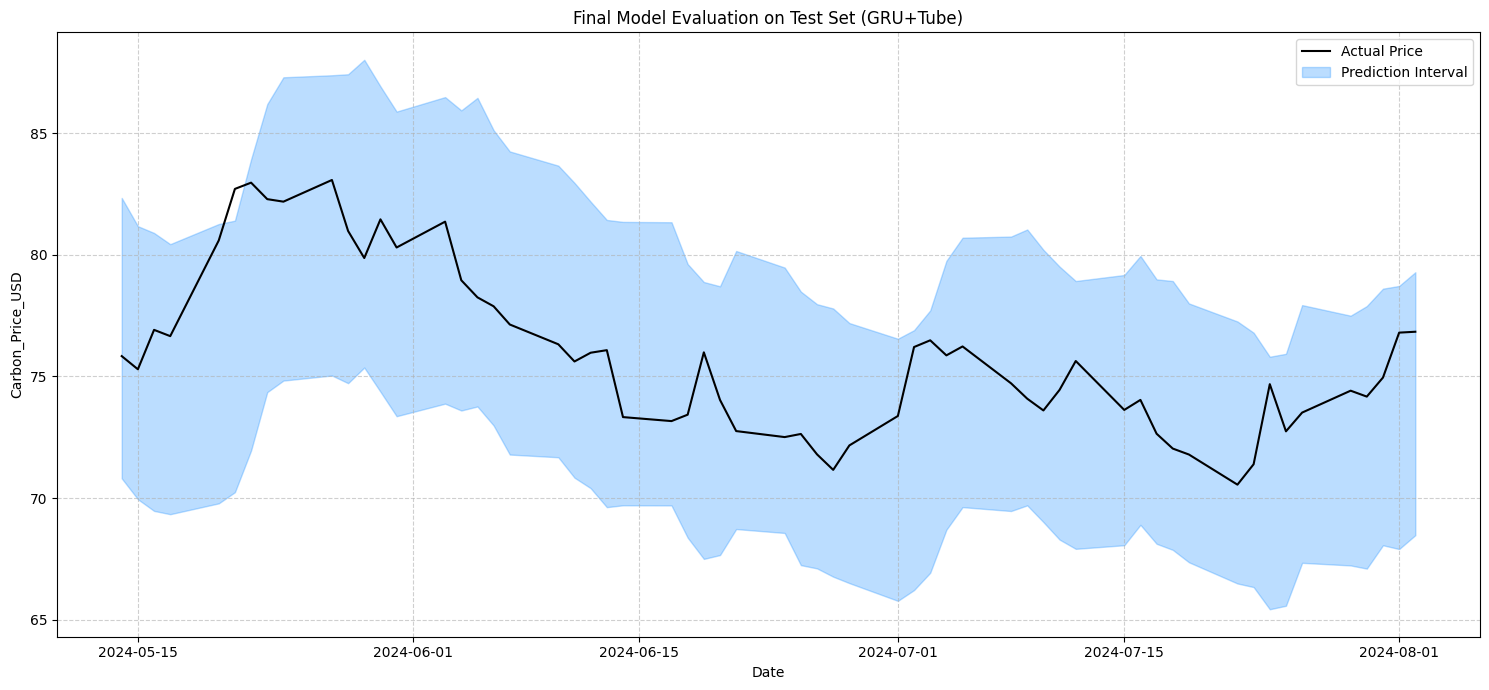

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import itertools
import logging

torch.manual_seed(42)
np.random.seed(42)

# --- 1. Configuration ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

CONFIG = {
    "file_path": r"C:\Users\DAIICT I\Desktop\Msc DS Sujal 202418017\Interval_Forecast_Normal\df_without_exo.xlsx",
    "target_col": "Carbon_Price_USD",
    "original_features": ['Carbon_Price_USD'],
    
    # --- Splitting Logic ---
    "test_split_date": '2024-04-01',
    "val_ratio_of_train_data": 0.1,
    
    "target_coverage": 95.0,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    
    "param_grid": {
        'seq_len': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 25, 30],
        'hidden_dim': [32, 48, 64, 96, 128, 160],
        'num_layers': [1, 2, 3],
        'learning_rate': [0.005, 0.01],
        'epochs': [100],
        # --- Tube Loss Hyperparameters to be Tuned ---
        'q': [0.95],
        'r': [0.4, 0.5, 0.6],
        'delta': [0.0, 0.01, 0.1]
    }
}

# --- 2. Model Definition & Loss Function ---

class GRUTube(nn.Module):
    """GRU model designed to output two values for the prediction interval."""
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super().__init__()
        # CHANGED: Use nn.GRU instead of nn.LSTM
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        # The final layer still outputs 2 values
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

def confidence_loss(y_pred, y_true, q, r, delta):
    # This loss function remains the same
    y_true = y_true.squeeze(-1)
    f2 = y_pred[:, 0]
    f1 = y_pred[:, 1]
    crossover_penalty = torch.mean(torch.relu(f1 - f2))
    c1 = (1 - q) * (f2 - y_true)
    c2 = (1 - q) * (y_true - f1)
    c3 = q * (f1 - y_true)
    c4 = q * (y_true - f2)
    loss_part1 = torch.where(y_true > r * (f1 + f2), c1, c2)
    loss_part2 = torch.where(f1 > y_true, c3, c4)
    is_inside = torch.logical_and(y_true <= f2, y_true >= f1)
    width_penalty = delta * torch.abs(f1 - f2)
    final_loss = torch.where(is_inside, loss_part1, loss_part2) + width_penalty
    return torch.mean(final_loss) + crossover_penalty

# --- CRPS Score Function ---
def crps_score(y_true, pred_lower, pred_upper):
    """
    Calculates the CRPS for a quantile-based forecast.
    This is an approximation based on the two quantiles.
    
    Args:
        y_true (np.array): The true values.
        pred_lower (np.array): The lower quantile predictions (e.g., 2.5th).
        pred_upper (np.array): The upper quantile predictions (e.g., 97.5th).

    Returns:
        float: The average CRPS score.
    """
    alpha = 0.05  # For a 95% interval (1 - alpha)
    
    crps = np.mean(
        (y_true - pred_lower) * ((y_true > pred_lower) - (1 - alpha / 2)) +
        (pred_upper - y_true) * ((y_true < pred_upper) - (alpha / 2))
    )
    return crps

# --- 3. Pipeline Functions ---

def load_and_clean_data(file_path):
    # This function remains the same
    logging.info(f"Loading data from {file_path}...")
    df = pd.read_excel(file_path) 
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    df.sort_values('Date', inplace=True)
    if pd.api.types.is_object_dtype(df['Vol.']):
        def convert_volume(vol):
            try:
                if isinstance(vol, str):
                    vol = vol.replace('K', '*1e3').replace('M', '*1e6')
                    return eval(vol)
                return np.nan
            except: return np.nan
        df['Vol.'] = df['Vol.'].apply(convert_volume)
    df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')
    df['Change %'] = pd.to_numeric(df['Change %'], errors='coerce')
    df.set_index('Date', inplace=True)
    return df

def engineer_features(df, original_features, target_col):
    # This function remains the same
    logging.info("Engineering lagged features...")
    for feature in original_features:
        df[f'{feature}_lag1'] = df[feature].shift(1)
    feature_cols = [f'{col}_lag1' for col in original_features]
    df.dropna(inplace=True)
    if df.empty:
        raise ValueError("DataFrame is empty after feature engineering.")
    X = df[feature_cols]
    y = df[[target_col]]
    return X, y

def split_and_scale_data(X, y, test_split_date, val_ratio):
    # This function remains the same
    logging.info(f"Splitting test data at date: {test_split_date}")
    test_split_date = pd.to_datetime(test_split_date)
    train_val_mask = X.index < test_split_date
    X_train_val, X_test = X[train_val_mask], X[~train_val_mask]
    y_train_val, y_test = y[train_val_mask], y[~train_val_mask]
    val_split_index = int(len(X_train_val) * (1 - val_ratio))
    X_train, X_val = X_train_val[:val_split_index], X_train_val[val_split_index:]
    y_train, y_val = y_train_val[:val_split_index], y_train_val[val_split_index:]
    logging.info(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")
    if len(X_train) == 0 or len(X_val) == 0 or len(X_test) == 0:
         raise ValueError("One of the data splits is empty.")
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    y_train_scaled = scaler_y.fit_transform(y_train)
    X_val_scaled = scaler_X.transform(X_val)
    y_val_scaled = scaler_y.transform(y_val)
    X_test_scaled = scaler_X.transform(X_test)
    y_test_scaled = scaler_y.transform(y_test)
    return (X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, 
            X_test_scaled, y_test_scaled, scaler_y)

def create_sequences(X, y, seq_len):
    # This function remains the same
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i - seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

def train_tube_model(X_train, y_train, params):
    """Trains a single GRU Tube model."""
    # CHANGED: Instantiate GRUTube instead of LSTMTube
    model = GRUTube(
        X_train.shape[2], 
        params['hidden_dim'], 
        params['num_layers']
    ).to(CONFIG['device'])
    
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(CONFIG['device'])
    y_train_t = torch.tensor(y_train, dtype=torch.float32).to(CONFIG['device'])
    q, r, delta = params['q'], params['r'], params['delta']

    for _ in range(params['epochs']):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train_t)
        loss = confidence_loss(y_pred, y_train_t, q, r, delta)
        loss.backward()
        optimizer.step()
    return model

def find_best_hyperparameters(train_data, val_data, param_grid, scaler_y):
    # This function is modified to use CRPS for model selection
    X_train_scaled, y_train_scaled = train_data
    X_val_scaled, y_val_scaled = val_data
    valid_models = []
    param_combinations = list(itertools.product(*param_grid.values()))
    logging.info(f"Starting hyperparameter search over {len(param_combinations)} combinations...")

    for values in param_combinations:
        params = dict(zip(param_grid.keys(), values))
        X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, params['seq_len'])
        X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, params['seq_len'])
        if len(X_val_seq) == 0: continue
        model = train_tube_model(X_train_seq, y_train_seq, params)
        X_val_t = torch.tensor(X_val_seq, dtype=torch.float32).to(CONFIG['device'])
        with torch.no_grad():
            predictions = model(X_val_t).cpu().numpy()
        pred_upper_s = predictions[:, 0:1]
        pred_lower_s = predictions[:, 1:2]
        pred_lower = scaler_y.inverse_transform(pred_lower_s).flatten()
        pred_upper = scaler_y.inverse_transform(pred_upper_s).flatten()
        y_val_true = scaler_y.inverse_transform(y_val_seq).flatten()
        pred_lower, pred_upper = np.minimum(pred_lower, pred_upper), np.maximum(pred_lower, pred_upper)
        picp = np.mean((y_val_true >= pred_lower) & (y_val_true <= pred_upper)) * 100
        mpiw = np.mean(pred_upper - pred_lower)
        crps = crps_score(y_val_true, pred_lower, pred_upper)
        if picp >= CONFIG['target_coverage']:
            logging.info(f"✓ Valid model found: PICP={picp:.2f}%, MPIW={mpiw:.4f}, CRPS={crps:.4f} with params {params}")
            valid_models.append({'mpiw': mpiw, 'crps': crps, 'params': params})
        else:
            logging.info(f"✗ Model rejected: PICP={picp:.2f}% with params {params}")
    if not valid_models:
        raise ValueError("No valid hyperparameters found that meet the PICP threshold.")
    best_model_info = min(valid_models, key=lambda x: x['crps'])
    return best_model_info['params']

def evaluate_on_test_set(best_params, train_val_data, test_data, scaler_y):
    # This function is modified to include CRPS in the final results
    X_train_val_scaled, y_train_val_scaled = train_val_data
    X_test_scaled, y_test_scaled = test_data
    logging.info("Training final model on combined train+validation data...")
    X_train_val_seq, y_train_val_seq = create_sequences(X_train_val_scaled, y_train_val_scaled, best_params['seq_len'])
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, best_params['seq_len'])
    model = train_tube_model(X_train_val_seq, y_train_val_seq, best_params)
    logging.info("Evaluating final model on the test set...")
    X_test_t = torch.tensor(X_test_seq, dtype=torch.float32).to(CONFIG['device'])
    with torch.no_grad():
        predictions = model(X_test_t).cpu().numpy()
    pred_upper_s = predictions[:, 0:1]
    pred_lower_s = predictions[:, 1:2]
    pred_lower = scaler_y.inverse_transform(pred_lower_s).flatten()
    pred_upper = scaler_y.inverse_transform(pred_upper_s).flatten()
    y_test_true = scaler_y.inverse_transform(y_test_seq).flatten()
    pred_lower, pred_upper = np.minimum(pred_lower, pred_upper), np.maximum(pred_lower, pred_upper)
    final_picp = np.mean((y_test_true >= pred_lower) & (y_test_true <= pred_upper)) * 100
    final_mpiw = np.mean(pred_upper - pred_lower)
    final_crps = crps_score(y_test_true, pred_lower, pred_upper)
    results = {"picp": final_picp, "mpiw": final_mpiw, "crps": final_crps}
    plot_data = {"pred_lower": pred_lower, "pred_upper": pred_upper, "y_true": y_test_true}
    return results, plot_data

def plot_results(plot_data, test_dates):
    # This function remains the same
    logging.info("Generating final plot...")
    y_true = plot_data['y_true']
    dates_for_plot = test_dates[-len(y_true):]
    plt.figure(figsize=(15, 7))
    plt.plot(dates_for_plot, y_true, label='Actual Price', color='black', linewidth=1.5)
    plt.fill_between(dates_for_plot, plot_data['pred_lower'], plot_data['pred_upper'], 
                     color='dodgerblue', alpha=0.3, label=f'Prediction Interval')
    plt.title('Final Model Evaluation on Test Set (GRU+Tube)')
    plt.xlabel('Date')
    plt.ylabel(CONFIG['target_col'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- 4. Main Execution ---
def main():
    # This function remains the same
    df = load_and_clean_data(CONFIG['file_path'])
    X, y = engineer_features(df, CONFIG['original_features'], CONFIG['target_col'])
    (X_train_s, y_train_s, X_val_s, y_val_s, 
     X_test_s, y_test_s, scaler_y) = split_and_scale_data(
         X, y, 
         test_split_date=CONFIG['test_split_date'], 
         val_ratio=CONFIG['val_ratio_of_train_data']
    )
    best_params = find_best_hyperparameters(
        train_data=(X_train_s, y_train_s),
        val_data=(X_val_s, y_val_s),
        param_grid=CONFIG['param_grid'],
        scaler_y=scaler_y
    )
    X_train_val_s = np.concatenate((X_train_s, X_val_s), axis=0)
    y_train_val_s = np.concatenate((y_train_s, y_val_s), axis=0)
    final_results, plot_data = evaluate_on_test_set(
        best_params=best_params,
        train_val_data=(X_train_val_s, y_train_val_s),
        test_data=(X_test_s, y_test_s),
        scaler_y=scaler_y
    )
    print("\n" + "="*40)
    logging.info("Final Model Performance on Test Set")
    print("="*40)
    print(f"Best Hyperparameters: {best_params}")
    print(f"Prediction Interval Coverage (PICP): {final_results['picp']:.2f}%")
    print(f"Mean Prediction Interval Width (MPIW): {final_results['mpiw']:.4f}")
    print(f"Continuous Ranked Probability Score (CRPS): {final_results['crps']:.4f}")
    print("="*40 + "\n")
    test_dates_index = X[X.index >= pd.to_datetime(CONFIG['test_split_date'])].index
    plot_results(plot_data, test_dates=test_dates_index)

if __name__ == "__main__":
    main()